# Group Project - 3

| Sl.no | Team Member | UT EID |
|---	| ------	|---	|
| 1 | Chyavan Mysore Chandrashekar 	| CM65624 |
| 2 | Mark Moreno                  	|  |
| 3 | Parthiv Borgohain   	        |  |
| 4 | Soumith Reddy Palreddy       	|  |

<hr>

### Imports Required

In [1]:
from gurobipy import Model, GRB
from pandas import read_csv, DataFrame
from numpy import array, zeros, linspace, abs as np_abs
import matplotlib.pyplot as plt
from random import shuffle
from os.path import exists
from datetime import datetime

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

### Global Variables

In [2]:
# Global Variables
time_limit = 3600
max_m = 0
M = 10      # Tested what the max_m value would be in all the models
k_fold = 10

### Read and format the Training and Test Data

In [3]:
training_df = read_csv("training_data.csv")
X_train = training_df[[col for col in training_df.columns if "X" in col]]
X_train["X0"] = 1
X_train = X_train[sorted(X_train.columns, key=lambda x: int(str(x[1:])))]
y_train = training_df[[col for col in training_df.columns if "y" in col]]

In [4]:
X_train.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,1,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,1,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,1,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,1,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,1,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [5]:
y_train.head()

,y
0,8.536145
1,4.808344
2,-1.530427
3,-0.428243
4,0.566694


<hr>

In [6]:
test_df = read_csv("test_data.csv")
X_test = test_df[[col for col in test_df.columns if "X" in col]]
X_test["X0"] = 1
X_test = X_test[sorted(X_test.columns, key=lambda x: int(str(x[1:])))]
y_test = test_df[[col for col in test_df.columns if "y" in col]]

In [7]:
X_test.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,1,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,1,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,1,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,1,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [8]:
y_test.head()

,y
0,7.107949
1,5.796272
2,1.598651
3,2.532953
4,0.590685


### Direct Variable Selection – MIQP Solution

#### Build an MIQP Class

A class which solves and holds the solution details (of objective value and betas) in the class object

In [9]:
class MIQP:
    def __init__(self, k_var):
        self.A = None
        self.b = None
        self.sense = None
        self.Q = None
        self.C = None
        self.k = k_var

        self.model = None
        self.model_x = None
        self.model_con = None

    def fit(self, X, y):
        global max_m
        global time_limit
        
        X = array(X)
        y = array(y)
        self.m = X.shape[1]
        _2m_1 = 2*self.m-1
        
        Q = zeros((_2m_1, _2m_1))
        Q[:self.m,:self.m] = X.transpose() @ X
        
        C = zeros(_2m_1)
        C[:self.m] = -2 * (y.transpose() @ X)

        # constraints
        vtype = array(["C"]*self.m + ["B"]*(self.m-1))
        lb = array([-M]*self.m + [0]*(self.m-1))
        A = zeros((_2m_1, _2m_1))
        b = zeros(_2m_1)
        sense = array(['<']*(_2m_1))

        for i in range(1,self.m):
            A[i-1, [i,i+self.m-1]] = [-1,-M]
            A[self.m-1+i-1, [i,i+self.m-1]] = [1, -M]
        
        A[-1, self.m:] = 1
        b[-1] = self.k
        model = Model()
        model_x = model.addMVar(_2m_1,vtype=vtype, lb=lb)
        model_con = model.addMConstr(A, model_x, sense, b)
        model.setMObjective(Q, C, 0, sense=GRB.MINIMIZE)
        model.Params.OutputFlag = 0
        model.Params.TimeLimit = time_limit
        model.optimize()
        
        # max_m = max([max(np_abs(model_x.x)), max_m])
        self.model = model
        self.model_x = model_x
        self.model_con = model_con
        self.A = A
        self.b = b
        self.sense = sense
        self.Q = Q
        self.C = C

    def predict(self, X):
        return X @ self.model_x.x[:self.m]

#### Read previously optimized results or optimize

In [10]:
savpath_1 = "MIQP_cv_results.csv"
time_elapsed = None

if exists(savpath_1):
    cv_results = read_csv(savpath_1)
else:
    start_time = datetime.now() 
    cv_results = DataFrame([], columns=["N_Var", "Sum of SSEs"])
    for var_num in range(5, 51, 5):
        idx = list(range(len(X_train)))
        shuffle(idx)
        cut_length = len(idx)//k_fold
        kf_error = 0
        for i in range(k_fold):
            val_idx = idx[i*cut_length:(i+1)*cut_length]
            X_tr, X_val = X_train.loc[~X_train.index.isin(val_idx)], X_train.loc[X_train.index.isin(val_idx)]
            y_tr, y_val = y_train.loc[~y_train.index.isin(val_idx)], y_train.loc[y_train.index.isin(val_idx)]
            model = MIQP(k_var=var_num)
            model.fit(X_tr, y_tr["y"])
            sse = (y_val["y"] - model.predict(X_val)).map(lambda x: x**2).sum()
            kf_error += sse
        cv_results.loc[len(cv_results)] = [int(var_num), kf_error]
    cv_results.to_csv(savpath_1, index=False)
    # print(max_m)
    time_elapsed = datetime.now() - start_time
cv_results.sort_values(["Sum of SSEs","N_Var"]).head()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-29


,N_Var,Sum of SSEs
1,10.0,718.118409
2,15.0,765.662561
3,20.0,802.496775
9,50.0,822.632080
4,25.0,826.685392


#### Plots and Inferences

1. Time required for the optimization considering k in intervals of 5

In [11]:
if type(time_elapsed) != type(None):
    print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:31:59.830120


2. How the Sum of Squared Errors (summed over all 10-folds) vary with respect to the number of variables we use in the model

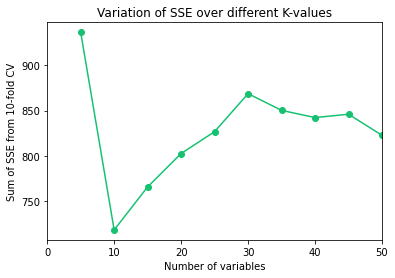

In [12]:
cv_results.plot(kind='line', x='N_Var', y='Sum of SSEs', marker="o", color="#16C172")
plt.ylabel("Sum of SSE from 10-fold CV")
plt.xlabel("Number of variables")
plt.legend('',frameon=False)
plt.xlim([0, 50])
plt.title("Variation of SSE over different K-values")
plt.savefig("cv_results.png", bbox_inches='tight')
plt.show()

3. Best k-value for the variable selection, and a model that fits the whole training data with the best k variables

In [13]:
k = int(cv_results.sort_values(["Sum of SSEs","N_Var"]).iloc[0]["N_Var"])
k

10

In [14]:
model = MIQP(k_var=k)
model.fit(X_train, y_train["y"])

In [15]:
comparison_df = DataFrame([], columns=["MIQP", "Lasso"])
comparison_df["MIQP"] = model.model_x.x[:51]

4. R<sup>2</sup> and Adjusted-R<sup>2</sup> for the best fit model

In [16]:
y_train["y_pred_MIQP"] = model.predict(X_train)
y_train["residuals_MIQP"] = y_train["y"] - y_train["y_pred_MIQP"]

TSS = (y_train["y"] - y_train["y"].mean()).map(lambda x: x**2).sum()
RSS = y_train["residuals_MIQP"].map(lambda x: x**2).sum()
n = len(y_train)
r_square = 1 - (RSS/TSS)
adj_r_square = 1 - ((RSS*(n-1))/(TSS*(n-k-1)))

print("For the most optimal model from MIQP for variable selection")
print(f"R_squared: {r_square.round(5)}")
print(f"Ajusted R_squared: {adj_r_square.round(5)}")

For the most optimal model from MIQP for variable selection
R_squared: 0.87834
Ajusted R_squared: 0.87325


5. Scatter plots to see how well the training data fits the response

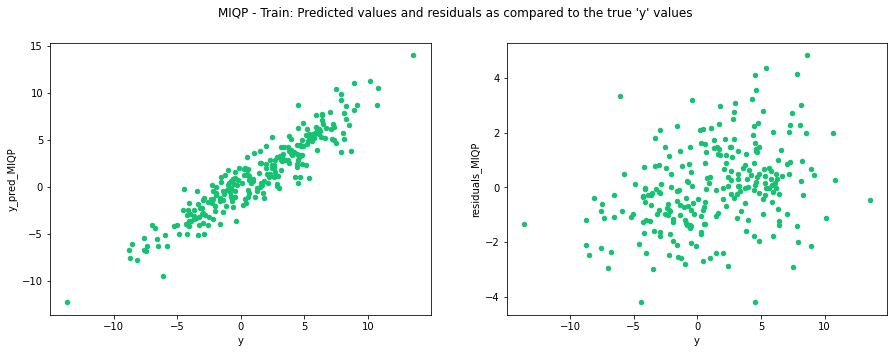

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

y_train.plot(kind="scatter", x="y", y="y_pred_MIQP", ax=axes[0], color="#16C172")
y_train.plot(kind="scatter", x="y", y="residuals_MIQP", ax=axes[1], color="#16C172")
plt.suptitle("MIQP - Train: Predicted values and residuals as compared to the true 'y' values")
plt.savefig("MIQP_scatter_training.png", bbox_inches='tight')
plt.show()

6. Scatter plots to see how well the test data fits the response

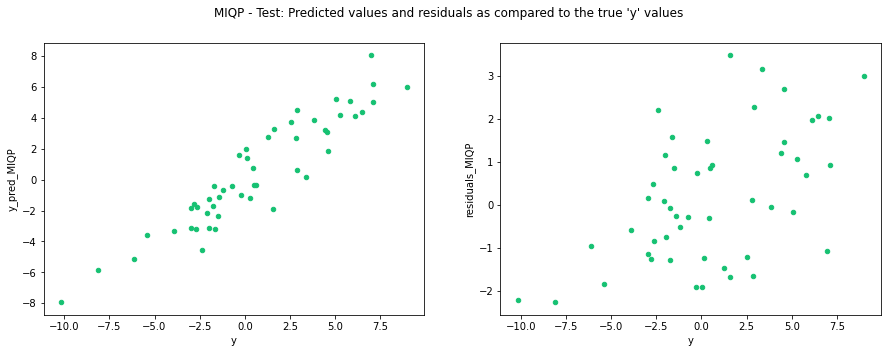

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

y_test["y_pred_MIQP"] = model.predict(X_test)
y_test["residuals_MIQP"] = y_test["y"] - y_test["y_pred_MIQP"]
y_test.plot(kind="scatter", x="y", y="y_pred_MIQP", ax=axes[0], color="#16C172")
y_test.plot(kind="scatter", x="y", y="residuals_MIQP", ax=axes[1], color="#16C172")
plt.suptitle("MIQP - Test: Predicted values and residuals as compared to the true 'y' values")
plt.savefig("MIQP_scatter_test.png", bbox_inches='tight')
plt.show()

7. Test MSE of the model

In [19]:
print("Test MSE for the best MIQP Model: ", (y_test["residuals_MIQP"]*y_test["residuals_MIQP"]).sum().round(2))

Test MSE for the best MIQP Model:  116.83


### Indirect Variable Selection – Lasso Regression

#### Read previously optimized results or optimize

In [20]:
savpath_2 = "Lasso_cv_results.csv"
time_elapsed = None

if exists(savpath_2):
    cv_results_lasso = read_csv(savpath_2)
else:
    start_time = datetime.now()
    cv_results_lasso = DataFrame([], columns=["Lambda", "Sum of SSEs"])
    lambdas = 10**linspace(-5,5,100)
    kf = KFold(n_splits=k_fold, random_state=15, shuffle=True)
    for lda in lambdas:
        kf_error = 0
        for tr_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train.iloc[tr_idx, 1:], X_train.iloc[val_idx, 1:]
            y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

            scaler = StandardScaler()
            scaler.fit(X_tr)
            Scaled_Xtr = scaler.transform(X_tr)
            Scaled_Xval = scaler.transform(X_val)
            
            model = Lasso(alpha=lda, normalize=True)
            model.fit(Scaled_Xtr, y_tr["y"])
            sse = (y_val["y"] - model.predict(Scaled_Xval)).map(lambda x: x**2).sum()
            kf_error += sse
        cv_results_lasso.loc[len(cv_results_lasso)] = [lda, kf_error]
    cv_results_lasso.to_csv(savpath_2, index=False)
    time_elapsed = datetime.now() - start_time
cv_results_lasso.sort_values(["Sum of SSEs", "Lambda"]).head()

,Lambda,Sum of SSEs
27,0.005337,727.832489
26,0.004229,730.341487
28,0.006734,733.278879
25,0.003352,736.079828
24,0.002656,745.728847


#### Plots and Inferences

1. Time required for the optimization considering k in intervals of 5

In [21]:
if type(time_elapsed) != type(None):
    print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:00:06.825173


2. How the Sum of Squared Errors (summed over all 10-folds) vary with respect to the $\lambda$ (penalizing term) in the Lasso regression

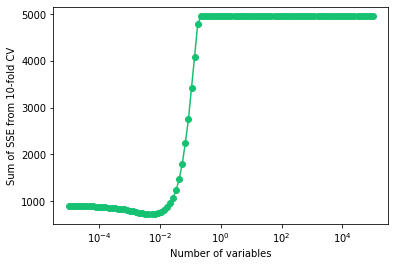

In [22]:
cv_results_lasso.plot(kind='line', x='Lambda', y='Sum of SSEs', marker="o", color="#16C172")
plt.ylabel("Sum of SSE from 10-fold CV")
plt.xlabel("Number of variables")
plt.legend('',frameon=False)
plt.xscale("log")
plt.savefig("cv_results_lasso.png", bbox_inches='tight')
plt.show()

3. Best $\lambda$, a model that fits the whole training data with this $\lambda$, and the corresponding number of variables

In [23]:
lda = cv_results_lasso.sort_values(["Sum of SSEs", "Lambda"]).iloc[0]["Lambda"]
lda

0.005336699231206307

In [24]:
model = Lasso(alpha=lda, normalize=True)
model.fit(X_train.iloc[:,1:], y_train["y"])

Lasso(alpha=0.005336699231206307, normalize=True)

In [25]:
comparison_df["Lasso"] = [model.intercept_, *model.coef_]

In [26]:
p = (model.coef_ != 0).sum()
p

18

4. R<sup>2</sup> and Adjusted-R<sup>2</sup> for the best fit model

In [27]:
y_train["y_pred_lasso"] = model.predict(X_train.iloc[:,1:])
y_train["residuals_lasso"] = y_train["y"] - y_train["y_pred_lasso"]

r_square = r2_score(y_train["y"], y_train["y_pred_lasso"])
adj_r_square = 1-(1-r_square)*(n-1)/(n-p-1)

print("For the most optimal model from Lasso for variable selection")
print(f"R_squared: {r_square.round(5)}")
print(f"Ajusted R_squared: {adj_r_square.round(5)}")

For the most optimal model from Lasso for variable selection
R_squared: 0.87866
Ajusted R_squared: 0.86921


5. Scatter plots to see how well the training data fits the response

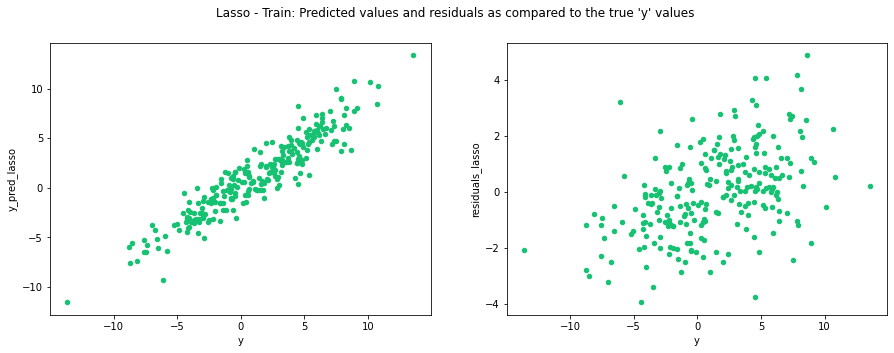

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

y_train.plot(kind="scatter", x="y", y="y_pred_lasso", ax=axes[0], color="#16C172")
y_train.plot(kind="scatter", x="y", y="residuals_lasso", ax=axes[1], color="#16C172")
plt.suptitle("Lasso - Train: Predicted values and residuals as compared to the true 'y' values")
plt.savefig("Lasso_scatter_training.png", bbox_inches='tight')
plt.show()

6. Scatter plots to see how well the test data fits the response

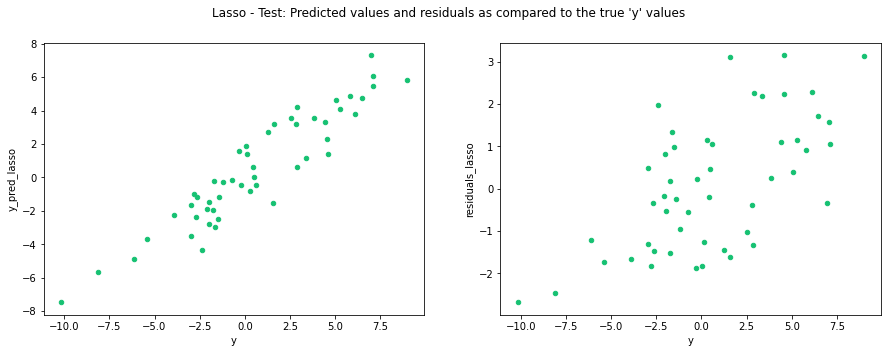

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

y_test["y_pred_lasso"] = model.predict(X_test.iloc[:,1:])
y_test["residuals_lasso"] = y_test["y"] - y_test["y_pred_lasso"]
y_test.plot(kind="scatter", x="y", y="y_pred_lasso", ax=axes[0], color="#16C172")
y_test.plot(kind="scatter", x="y", y="residuals_lasso", ax=axes[1], color="#16C172")
plt.suptitle("Lasso - Test: Predicted values and residuals as compared to the true 'y' values")
plt.savefig("Lasso_scatter_test.png", bbox_inches='tight')
plt.show()

7. Test MSE of the model

In [30]:
print("Test MSE for the best Lasso Model: ", (y_test["residuals_lasso"]*y_test["residuals_lasso"]).sum().round(2))

Test MSE for the best Lasso Model:  117.83


### Comparison

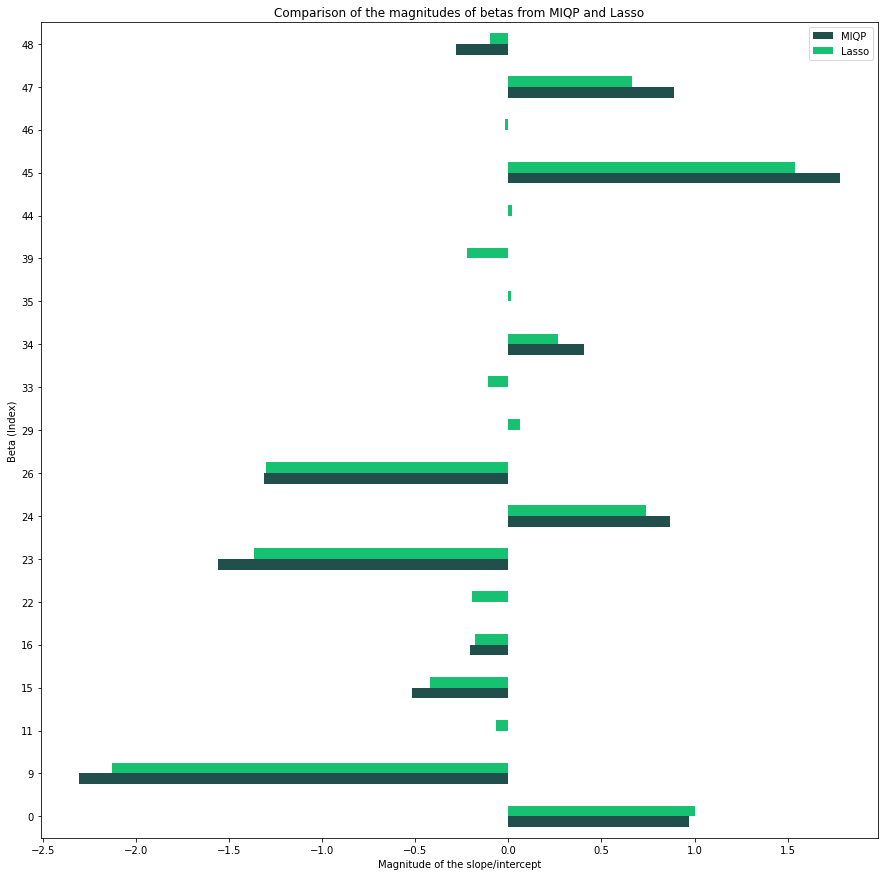

In [31]:
comparison_df = comparison_df[(comparison_df != 0)["MIQP"] | (comparison_df != 0)["Lasso"]]
comparison_df.plot.barh(figsize=(15,15), color=["#214F4B", "#16C172"])
plt.title("Comparison of the magnitudes of betas from MIQP and Lasso")
plt.ylabel("Beta (Index)")
plt.xlabel("Magnitude of the slope/intercept")
plt.savefig("comparison.png", bbox_inches='tight')
plt.show()